## Feature Extraction Using Librosa

1. Load the datasets
    - 1.1 Combine 3 datasets listed below and label with corresponding emotions
    - 1.2 Extract Features
        - 2.1 For Train data, there will be data augmentation, adding noise and pitch
        - 2.2 For Test data, extract librosa features

2. Features to be extracted:
    - 2.1. Root Mean Square
    - 2.2 Spectral Centroid
    - 2.3. Spectral Rolloff
    - 2.4. Zero Crossing Rate
    - 2.5. Chroma STFT
    - 2.6. MFCC
    - 2.7. Mel Spectogram

There  will be 184 features to be saved in test.csv and train.csv

#### SOURCE
[The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)](https://zenodo.org/record/1188976#.YmlBpS8RoTs)
[Toronto emotional speech set (TESS)](https://tspace.library.utoronto.ca/handle/1807/24487)
[Surrey Audio-Visual Expressed Emotion (SAVEE)Database](http://personal.ee.surrey.ac.uk/Personal/P.Jackson/SAVEE/Database.html)


In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#to list the files
from glob import glob

#for Audio processing
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold

### 01. Combine Datasets

In [2]:
def get_files(dir):
    
    files = glob(dir + '*/*.wav')
    print(f"{dir} file counts : ", len(files))
        
    return files

In [3]:
#define the directories/paths
ravdess_rootdir = './raw_source/RAVDESS/'
tess_rootdir = './raw_source/TESS/'
savee_rootdir = './raw_source/Savee/'

In [4]:
#get the files for each collection
ravdess = get_files(ravdess_rootdir)
tess =  get_files(tess_rootdir)
savee =  get_files(savee_rootdir)

./raw_source/RAVDESS/ file counts :  1440
./raw_source/TESS/ file counts :  2800
./raw_source/Savee/ file counts :  480


In [5]:
#this is the mapping for RAVDEE dataset, map the label into actual emotions or descriptions for easy analysis

dict_emotion = {
    
    "01" : "neutral", 
    "02" : "calm", 
    "03" : "happy",
    "04" : "sad",
    "05" : "angry",
    "06" : "fear",
    "07" : "disgust", 
    "08" : "surprised"
    
}

In [6]:
emotion = []
file = []
audio = []
source = []

#RAVDESS dataset, extract the emotion from filename
for r in ravdess:
    file.append(r)
    
    #save the audio
    data, _ = librosa.load(r)
    
    #get the emotion part
    emotion.append(dict_emotion[r.split("-")[2]])
    audio.append(data)
    source.append('ravdess')

In [7]:
#TESS dataset, extract the emotion from filename

for t in tess:
    
    file.append(t)
    
    #save the audio
    data, _ = librosa.load(t)
    
    #get the emotion part
    emo = t.split("_")[-1].split(".")[0]
    
    if emo == "ps":
        emo = "surprised"
        
    emotion.append(emo)
    audio.append(data)
    source.append('tess')

In [8]:
#SAVEE dataset, extract the emotion from filename

for s in savee:
    
    file.append(s)
    
    #save the audio
    data, _ = librosa.load(s)
    
    filename= s.split('/')
    label = filename[4]
    
    if label[0] == 'a':
        emotion.append('angry')
    elif label[0] == 'd':
        emotion.append('disgust')
    elif label[0] == 'f':
        emotion.append('fear')
    elif label[0] == 'h':
        emotion.append('happy')
    elif label[0] == 'n':
        emotion.append('neutral')
    elif label[0:2] == 'sa':
        emotion.append('sad')
    elif label[0:2] == 'su':
        emotion.append('surprised')
    else:
         emotion.append('unknown')
            
    audio.append(data)
    source.append('savee')

In [9]:
#convert to dataframe
data = {'file':file, 
        'emotion':emotion,
        'audio':audio,
        'source': source}
df_all = pd.DataFrame(data)

In [10]:
#total 
df_all.shape

(4720, 4)

Text(0.5, 1.0, ' Count by Emotions')

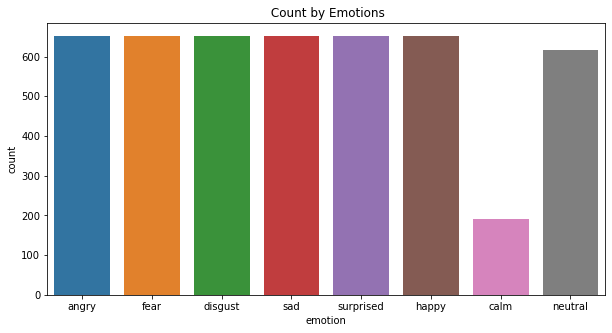

In [11]:
#distribution of the data
plt.figure(figsize=(10,5))
sns.countplot(data = df_all, x="emotion")
plt.title(" Count by Emotions")


## Calm is only present in RAVDESS and not in TESS and SAVEE, we will drop this and we will only predict 7 emotions

In [12]:
df_all = df_all[df_all["emotion"] != 'calm']

In [13]:
#less calm
df_all.shape

(4528, 4)

In [14]:
df_all.to_csv('./dataset/all_raw.csv')

In [15]:
df_all.head()

,file,emotion,audio,source
0,./raw_source/RAVDESS/Actor_16/03-01-05-01-02-0...,angry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ravdess
1,./raw_source/RAVDESS/Actor_16/03-01-06-01-02-0...,fear,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ravdess
2,./raw_source/RAVDESS/Actor_16/03-01-06-02-01-0...,fear,"[3.0036153e-05, 2.7443759e-05, 9.890327e-07, 6...",ravdess
3,./raw_source/RAVDESS/Actor_16/03-01-05-02-01-0...,angry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ravdess
4,./raw_source/RAVDESS/Actor_16/03-01-07-01-01-0...,disgust,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ravdess


### 02.  FEATURE EXTRACTION

In [16]:
sample_rate = 22050

In [17]:
def librosa_features(data):
    
    '''this will create an array of some librosa features
    (e.g. zero_crossing_rate, root mean square energy, spectral centroid and rollfoof,
        chroma_stft, mfcc, rms, melspectrogram)
    concatenated for each audio'''
    
    
    result = np.array([])
    
   
    # Root Mean Square Value (one column, the average )
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # add as column 

    
     # Spectral Centroid (one column, the average )
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_centroid)) # stacking horizontally
    
    
        
     # Spectral Rolloff (one column, the average )
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff)) # add as column 
    
        
    
    # Zero Crossing Rate (one column, the average )
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # add as column 
    

    
    # Chroma_stft (12 columns)
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    
    # MFCC  (40 columns)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
      
    
    # MelSpectogram (128 columns)
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
        
    return result

def get_basic_features(audio):
    ''' get librosa features only for the test dataset '''
        
    #Trim leading and trailing silence from an audio signal.
    yt, index = librosa.effects.trim(audio)
    
    
    #librosa features
    res1 = librosa_features(yt)

    
    return res1

In [18]:
##functions for data augmentation

#default values, can change accordingly
v_random_noise = 0.030
v_stretch_rate = 0.75
v_shift_low = -5
v_shift_high = 5
v_pitch_factor = 0.8

def add_noise(data):
    noise_amp = v_random_noise*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def add_stretch(data, rate=v_stretch_rate):
    return librosa.effects.time_stretch(data, rate=rate)

def add_pitch(data, sampling_rate, pitch_factor= v_pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [19]:
def get_features_extra(audio):
    
    ''' get librosa features plus data augmentation for the train dataset '''
        
    #Trim leading and trailing silence from an audio signal
    yt, index = librosa.effects.trim(audio)
    
    # only libroras features
    res1 = librosa_features(yt)
    result = np.array(res1)
    
    ### with data augmentation
    
    # data with noise
    noise_data = add_noise(yt)
    res2 = librosa_features(noise_data)
    result = np.vstack((result, res2)) # as new record
    
    # data with stretching and pitching
    new_data = add_stretch(yt)
    data_stretch_pitch = add_pitch(new_data, sample_rate)
    res3 = librosa_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # as new record
    
    return result

In [20]:
# splitting data
train,test = train_test_split(df_all, random_state=0, shuffle=True, stratify=df_all['emotion'])

In [21]:
#validate the distribution of data is even for train and test for each emotion
train["emotion"].value_counts(normalize=True)

fear         0.143993
happy        0.143993
surprised    0.143993
sad          0.143993
angry        0.143993
disgust      0.143993
neutral      0.136042
Name: emotion, dtype: float64

In [22]:
#validate the distribution of data is even for train and test for each emotion
test["emotion"].value_counts(normalize=True)

disgust      0.143993
fear         0.143993
happy        0.143993
sad          0.143993
angry        0.143993
surprised    0.143993
neutral      0.136042
Name: emotion, dtype: float64

In [23]:
#need to save the no of records for train
shape_train = train.shape
shape_train

(3396, 4)

In [24]:
#need to save the no of records for test
shape_test = test.shape
shape_test

(1132, 4)

In [25]:
def train_withAugmentation(df):
    
    ''' the number of records will be times three, we are adding two records, one with noise, the other with pitch'''
    librosa_X, librosa_y, librosa_f = [], [], []
    
    for x, row in df.iterrows():
    
        #librosa with  noise, stretching
        feat = get_features_extra(row["audio"])
    
        for f in feat:
            librosa_X.append(f)
            librosa_y.append(row["emotion"])
            librosa_f.append(row["file"])
    
    df_feature = pd.DataFrame(librosa_X)
    df_feature['label'] = librosa_y
    df_feature['file'] = librosa_f

    return df_feature

In [26]:
def test_noAugmentation(df):
    
    ''' just the librosa features '''
    
    librosa_X, librosa_y, librosa_f = [], [], []
    
    for x,row in df.iterrows():
        
        feat = get_basic_features(row["audio"])

        librosa_X.append(feat)
        librosa_y.append(row["emotion"])
        librosa_f.append(row["file"])
    
    df_feature = pd.DataFrame(librosa_X)
    df_feature['label'] = librosa_y
    df_feature['file'] = librosa_f
    
    return df_feature

In [27]:
#feature extraction for train dataset with augmentation
train_proc = train_withAugmentation(train)

In [28]:
#no of records should be x3
print('Train after processing: ', train_proc.shape, 'Expected:', train_proc.shape[0]*3)

#testing
assert train_proc.shape[0] == shape_train[0]*3

Train after processing:  (10188, 186) Expected: 30564


In [29]:
#feature extraction for test dataset
test_proc = test_noAugmentation(test)

In [30]:
test_proc.head()

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,181,182,183,label,file
0,0.010871,2547.460692,4225.225761,0.146462,0.350376,0.489627,0.388288,0.277398,0.330770,0.440719,...,0.000159,1.770702e-04,1.284800e-04,1.070036e-04,9.785273e-05,7.668910e-05,2.502960e-05,1.583275e-06,neutral,./raw_source/TESS/OAF_neutral/OAF_sub_neutral.wav
1,0.014300,1825.103691,2837.405799,0.099402,0.435393,0.508717,0.566287,0.620762,0.594975,0.504975,...,0.000656,4.537473e-04,4.394072e-04,3.523740e-04,2.447775e-04,1.527458e-04,4.183541e-05,2.718440e-06,disgust,./raw_source/TESS/OAF_disgust/OAF_knock_disgus...
2,0.002364,3178.091805,5857.320286,0.287401,0.650888,0.591952,0.608699,0.609804,0.553792,0.563674,...,0.000046,9.197745e-05,1.416200e-04,1.751091e-04,3.004984e-04,1.877091e-04,2.995609e-05,2.822386e-06,fear,./raw_source/RAVDESS/Actor_06/03-01-06-01-01-0...
3,0.127967,1101.501296,1980.794205,0.027615,0.592087,0.558594,0.529101,0.503935,0.516974,0.592902,...,0.000002,9.104003e-07,9.869351e-07,9.132608e-07,9.256651e-07,3.880744e-07,1.712170e-07,4.390066e-08,happy,./raw_source/Savee/JE/h13.wav
4,0.006590,2747.088848,5786.171989,0.182969,0.713597,0.755569,0.742611,0.696970,0.663825,0.642817,...,0.000117,1.087833e-04,9.435938e-05,1.028792e-04,1.043497e-04,7.786060e-05,2.384895e-05,2.291553e-06,sad,./raw_source/RAVDESS/Actor_11/03-01-04-02-01-0...


In [31]:
#there should be no changes in the no of records
print(test_proc.shape)

#testing
assert test_proc.shape[0] == shape_test[0]

(1132, 186)


### Train and Test Dataset

In [32]:
##save to file for MODELLING

train_proc.to_csv("./dataset/train.csv")
test_proc.to_csv("./dataset/test.csv")